In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [0]:
import random
from sklearn.model_selection import train_test_split

## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Given function

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


__Data collection function.__

In [0]:
def apply_mask_1(im, mask, color=1):
    #all tissue color = 1
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
def get_patch(slide, tumor_mask, lev, x_1, y_1, patch_size_x,patch_size_y):
  #downsample_size
  # downsample_size = 2 ** lev
  # x_1 = x_1*downsample_size
  # y_1 = y_1*downsample_size
  #
  slide_image = read_slide(slide, 
                      x=x_1, 
                      y=y_1, 
                      level=lev,
                      width = patch_size_x,
                      height = patch_size_y)

  mask_image = read_slide(tumor_mask, 
                      x=x_1, 
                      y=y_1, 
                      level=lev,
                      width = patch_size_x,
                      height = patch_size_y)
  
  mask_image = mask_image[:,:,0]
  
  tissue_pixels = list(find_tissue_pixels(slide_image))
  tissue_regions = apply_mask(slide_image,tissue_pixels)
  tissue_regions_1 = apply_mask_1(slide_image,tissue_pixels)
  tissue_mask = tissue_regions[:,:,0]
  #percent_tissue = len(tissue_pixels) / float(slide_image_level3_whole.shape[0] * slide_image_level3_whole.shape[0]) * 100
  return slide_image, mask_image, tissue_regions, tissue_mask

In [0]:
def generate_good_bad_cell_location(slide,tumor_mask, lev):
  whole_slide_lev, whole_mask_lev, whole_tissue_regions, whole_tissue_mask = get_patch(slide,
                                                                                       tumor_mask,
                                                                                       lev,
                                                                                       0,
                                                                                       0,
                                                                                       slide.level_dimensions[lev][0],
                                                                                       slide.level_dimensions[lev][1])
  # return the index list of good and bad cell
  bad_cell = []
  good_cell= []
  bad_cell_index = np.nonzero(whole_mask_lev)
  for n in range(len(bad_cell_index[0])):
    a = (bad_cell_index[1][n],bad_cell_index[0][n])
    bad_cell.append(a)
  good_cell_index = np.nonzero(whole_tissue_mask-whole_mask_lev)
  for m in range(len(good_cell_index[0])):
    b = (good_cell_index[1][m],good_cell_index[0][m])
    good_cell.append(b)
  return good_cell, bad_cell

In [0]:
def label_of_patch(mask_image):
  context_size = mask_image.shape[0]
  center = int((context_size-128)/2)
  if not (mask_image[center:context_size-center,center:context_size-center] == 0).all():
    label = 1
  else:
    label = 0
  return label

In [0]:
def single_slide_given_level_patch_datas(slide_path,tumor_mask_path,lev,cell_ratio):
  patch_data = []
  patch_label = []
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  #Got the index list of good and bad cell in previous level on this slide
  good_cell, bad_cell = generate_good_bad_cell_location(slide,tumor_mask, lev)
  bad_cell =  random.sample(bad_cell,100)
  good_cell = random.sample(good_cell,cell_ratio*len(bad_cell))
  for n in range(len(good_cell)):
    (x,y) = good_cell[n]
    downsample_size = 2**(lev)
    x_1 = x*downsample_size
    y_1 = y*downsample_size
    #Get patch and label
    slide_image, mask_image, tissue_regions, tissue_mask = get_patch(slide, tumor_mask, lev, x_1, y_1,299,299)
    patch_data.append(tissue_regions)
    #Get label
    patch_label.append(label_of_patch(mask_image))
  for n in range(len(bad_cell)):
    (x,y) = bad_cell[n]
    downsample_size = 2**(lev)
    x_1 = x*downsample_size
    y_1 = y*downsample_size
    #Get patch and label
    slide_image, mask_image, tissue_regions, tissue_mask = get_patch(slide, tumor_mask, lev, x_1, y_1,299,299)
    patch_data.append(tissue_regions)
    #Get label
    patch_label.append(label_of_patch(mask_image))
  return patch_data, patch_label

## Start from single slide

In [0]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [0]:
patch_data,patch_label = single_slide_given_level_patch_datas(slide_path,tumor_mask_path,3,1)

In [0]:
X_trainval = np.asarray(patch_data)
y_trainval = np.asarray(patch_label)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval , test_size=0.2, random_state=42, stratify=y_trainval, shuffle=True)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = train_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)

In [0]:
conv_base_incept = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(299, 299, 3))
model = tf.keras.Sequential([
        conv_base_incept,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 55,357,729
Trainable params: 55,323,297
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=val_generator,
    validation_steps=50)

Epoch 1/5
100/100 [==============================] - 71s 713ms/step - loss: 0.2215 - accuracy: 0.9228 - val_loss: 1.5096 - val_accuracy: 0.6228
Epoch 2/5
100/100 [==============================] - 71s 706ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 2.7064 - val_accuracy: 0.6116
Epoch 3/5
100/100 [==============================] - 71s 714ms/step - loss: 0.0069 - accuracy: 0.9962 - val_loss: 2.1992 - val_accuracy: 0.7143
Epoch 4/5
100/100 [==============================] - 71s 708ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.0967 - val_accuracy: 0.8616
Epoch 5/5
100/100 [==============================] - 71s 709ms/step - loss: 4.1498e-05 - accuracy: 1.0000 - val_loss: 1.1934 - val_accuracy: 0.9115


__Result of single slide model.__

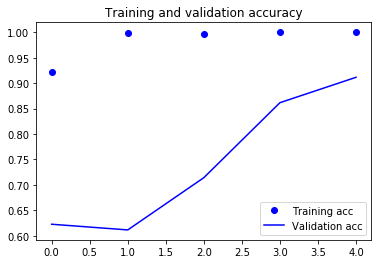

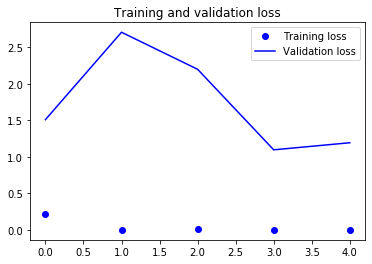

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

__The validation accuracy goes up and loss goes down, which means the model works, we can move to multipy layer model.__

## Multipy layer model function.##

In [0]:
def heat_map(slide_path,tumor_mask_path,model_lev):
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  whole_slide_lev7, whole_mask_lev7, whole_tissue_regions_7, whole_tissue_mask_7 = get_patch(slide,
                                                                                      tumor_mask,
                                                                                      7,
                                                                                      0,
                                                                                      0,
                                                                                      slide.level_dimensions[7][0],
                                                                                      slide.level_dimensions[7][1])
  #get the tissue index in lev7
  tissue_cell = []
  tissue_cell_index = np.nonzero(whole_tissue_mask_7)
  for m in range(len(tissue_cell_index[0])):
    b = (tissue_cell_index[1][m],tissue_cell_index[0][m])
    tissue_cell.append(b)
  #points_number = len(tissue_cell)//10
  tissue_cell = random.sample(tissue_cell,2000)


  #Get the predict patchs 
  predict_patch_data=[]
  for n in range(len(tissue_cell)):
    (x,y) = tissue_cell[n]
    downsample_size = 2**(7)
    x_1 = x*downsample_size - int(299/2)
    y_1 = y*downsample_size - int(299/2)
    #Get patch and label
    slide_image, mask_image, tissue_regions, tissue_mask = get_patch(slide, tumor_mask, model_lev, x_1, y_1,299,299)
    predict_patch_data.append(tissue_regions)
  
  #Get predict value
  X = np.asarray(predict_patch_data)
  X = X/255.0
  pred_value = model.predict(X)
  #plot heatmap
  del predict_patch_data
  heatmap = np.zeros(whole_slide_lev7.shape[:2])
  for n in range(len(tissue_cell)):
    (x,y) = tissue_cell[n]
    # pred_array = np.zeros((2,2))
    # pred_array[:,:] = pred_value[n]
    if pred_value[n] > 0.98:
      heatmap[y-5:y+5, x-5:x+5] = pred_value[n]
  fig, axes = plt.subplots(1,2, figsize=(20,10), dpi=100)
  a = axes[0]
  a.imshow(whole_mask_lev7)
  a = axes[1]
  a.imshow(whole_slide_lev7)
  a.imshow(heatmap, cmap='viridis', alpha=0.8)
  plt.show()
  return heatmap

In [0]:
def mulipy_layer(path_list):
  total_patch_list = []
  total_label_list = [] 
  for fp in path_list:
    slide_path ='/content/drive/My Drive/new_slides/Copy of tumor_' + fp +'.tif'
    tumor_mask_path = '/content/drive/My Drive/new_slides/Copy of tumor_' + fp+'_mask.tif'
    patch_data,patch_label = single_slide_given_level_patch_datas(slide_path,tumor_mask_path,4,1)
    total_patch_list = total_patch_list + patch_data
    total_label_list = total_label_list + patch_label
  return total_patch_list,total_label_list

__Start from 4 slides to build model.__

In [0]:
path_list = ['110','101','081','016','019','023','031','002','035','059','064']
tot_pa, tot_lab = mulipy_layer(path_list)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
X_trainval = np.asarray(tot_pa)
y_trainval = np.asarray(tot_lab)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval , test_size=0.2, random_state=42, stratify=y_trainval, shuffle=True)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = train_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)

Using TensorFlow backend.


In [0]:
conv_base_incept = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(299, 299, 3))
model = tf.keras.Sequential([
        conv_base_incept,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=7,
    validation_data=val_generator,
    validation_steps=50)

Epoch 1/7
100/100 [==============================] - 100s 1s/step - loss: 0.2712 - accuracy: 0.8978 - val_loss: 0.8938 - val_accuracy: 0.8135
Epoch 2/7
100/100 [==============================] - 93s 934ms/step - loss: 0.0867 - accuracy: 0.9675 - val_loss: 0.3460 - val_accuracy: 0.9239
Epoch 3/7
100/100 [==============================] - 93s 928ms/step - loss: 0.0446 - accuracy: 0.9825 - val_loss: 0.3255 - val_accuracy: 0.9473
Epoch 4/7
100/100 [==============================] - 93s 927ms/step - loss: 0.0264 - accuracy: 0.9903 - val_loss: 0.1889 - val_accuracy: 0.9594
Epoch 5/7
100/100 [==============================] - 93s 934ms/step - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.1435 - val_accuracy: 0.9727
Epoch 6/7
100/100 [==============================] - 93s 930ms/step - loss: 0.0079 - accuracy: 0.9969 - val_loss: 0.1709 - val_accuracy: 0.9765
Epoch 7/7
100/100 [==============================] - 92s 924ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.1513 - val_accuracy: 0

__Get the result plot and heatmap over one other slide in level 7.__

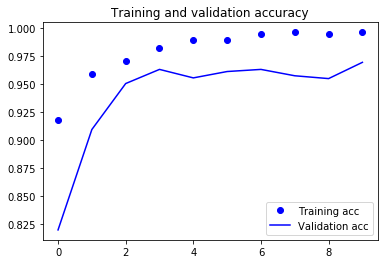

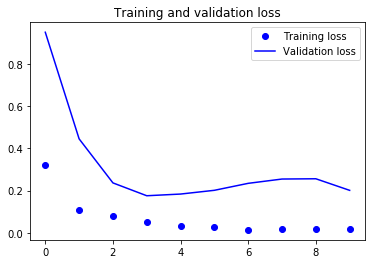

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

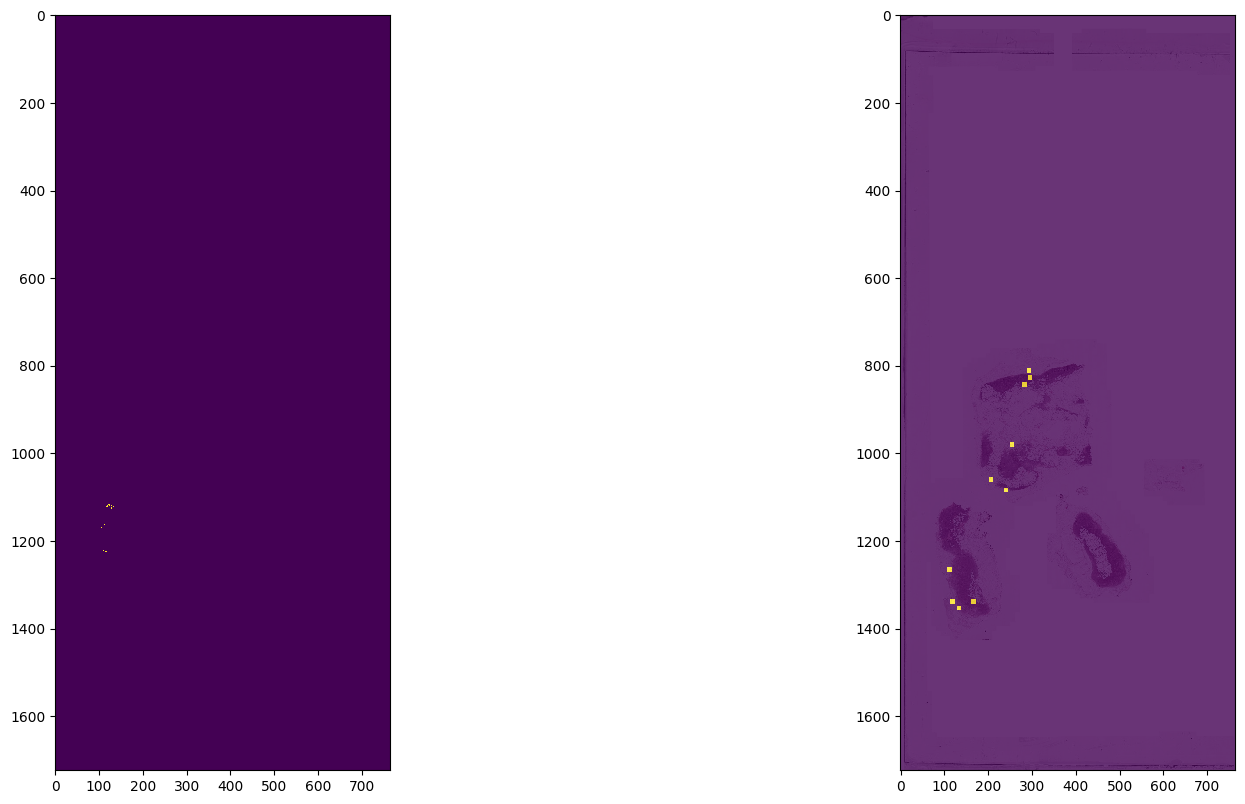

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
slide_path = '/content/drive/My Drive/new_slides/Copy of tumor_057.tif'
tumor_mask_path = '/content/drive/My Drive/new_slides/Copy of tumor_057_mask.tif'
heat_map(slide_path,tumor_mask_path,4)

In [0]:
test_data,test_label = single_slide_given_level_patch_datas(slide_path,tumor_mask_path,4,1)
X_test = np.asarray(test_data)
Y_test = np.asarray(test_label)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32, shuffle=True)


In [0]:
model.evaluate_generator(test_generator,steps=50)

[0.5472246452777051, 0.9155028]

## Questions:
  1.When we get the pixels form one level of a slide, should we balance the number of cancer cell with good cell?
  
  2.If I use a balance dataset, it's necessary to use data augmentation? How can we use data augmentation only for cancer cell? 
  
  3.How can we use more than one level data as our input? Should it be the same dimension?

  4.Is there any suggestion for building our own model?